In [110]:
import pandas as pd
import numpy as np

from sklearn import ensemble
from sklearn.grid_search import RandomizedSearchCV

from matplotlib import pyplot as plt
%matplotlib inline


# RF_v1_FE_v2

Model: 
Previously best performing RandomFores model, which did not have the best LB score, but made the highest amount of money so far, it's origin is on ROUND_20160811

Data: 
Polynomial feature engineering, with degree=2 + basic stats, using feature engineered variables. Original data is included. 

In [76]:
# Load data
train = pd.read_csv('Data/FE_v2_train.csv')
test = pd.read_csv('Data/FE_v2_test.csv')
train_y = pd.read_csv('Data/train_y.csv')
submission = pd.read_csv('CleanData/example_predictions.csv')

# Set models
params_rf = {'oob_score': True, 
             'n_jobs': 4, 
             'verbose': 0, 
             'min_samples_leaf': 10, 
             'n_estimators': 250, 
             'max_features': 50, 
             'random_state': 42, 
             'criterion': 'gini', 
             'min_samples_split': 5, 
             'max_depth': 5
            }
model_rf = ensemble.RandomForestClassifier(**params_rf)

# Fit model, and make predictions
model_rf.fit(train, train_y.target)
predictions = model_rf.predict_proba(test.iloc[:,1:])

submission.probability = predictions[:,1]

In [4]:
pd.DataFrame.to_csv(submission, 'Submissions/RFv1_FEv2.csv', index=False)

# Logloss Score: 0.69080

## Metamodel rank when uploaded: 93

# Best performing model so far

Metarank when last time checked: 98 (this is still the best performing model)

# Feature importance

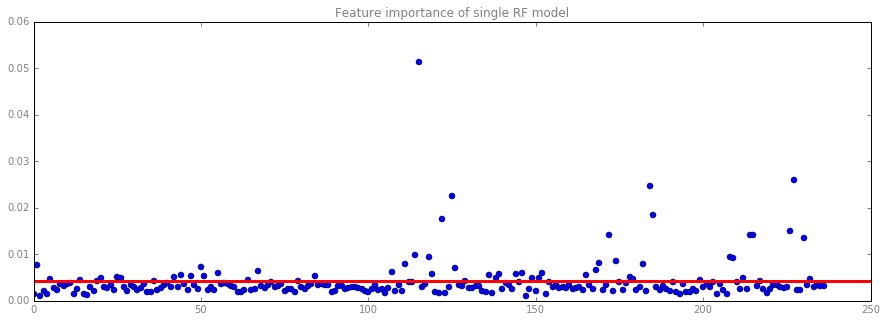

In [60]:
fig = plt.figure()
fig.set_size_inches(15,5)
plt.yticks(color='grey')
plt.xticks(color='grey')
plt.title('Feature importance of single RF model', color='grey')

temp = model_rf.feature_importances_

plt.plot(temp, 'o')
plt.axhline(model_rf.feature_importances_.mean(), color='red', linewidth=3)

In [61]:
len(temp[temp > temp.mean()]) / float(len(temp))

0.22784810126582278

Let's try to drop all the variables below the importance's mean, set a new train and test dataset, and run the previous (same) model once again. 

It would be nice to cross validate it, but I'll just check out LB score. If it helped, I'll check the CV score. 

In [68]:
# keep variables above the mean only
test_tid = pd.DataFrame(test.t_id)
test.drop('t_id', axis=1, inplace=True)
test = test.loc[:, temp>temp.mean()]
test = pd.concat([test_tid, test], axis=1)

train = train.loc[:, temp>temp.mean()]

In [72]:
# Set models
params_rf = {'oob_score': True, 
             'n_jobs': 4, 
             'verbose': 0, 
             'min_samples_leaf': 10, 
             'n_estimators': 250, 
             'max_features': 50, 
             'random_state': 42, 
             'criterion': 'gini', 
             'min_samples_split': 5, 
             'max_depth': 5
            }
model_rf = ensemble.RandomForestClassifier(**params_rf)

# Fit model, and make predictions
model_rf.fit(train, train_y.target)
predictions = model_rf.predict_proba(test.iloc[:,1:])

submission.probability = predictions[:,1]

In [73]:
pd.DataFrame.to_csv(submission, 'Submissions/RFv1_FEv2_imp_v1.csv', index=False)

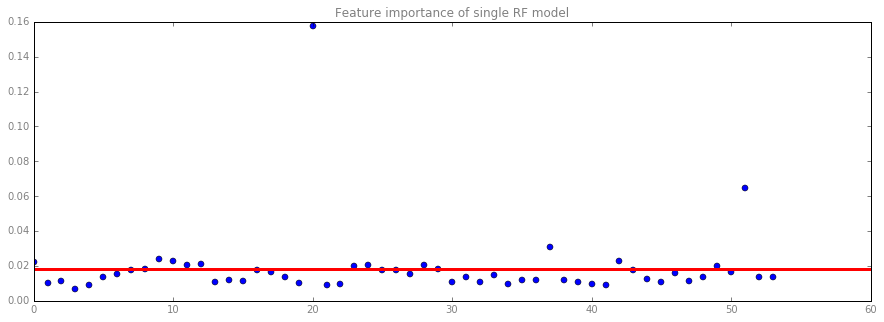

In [75]:
fig = plt.figure()
fig.set_size_inches(15,5)
plt.yticks(color='grey')
plt.xticks(color='grey')
plt.title('Feature importance of single RF model', color='grey')

temp = model_rf.feature_importances_

plt.plot(temp, 'o')
plt.axhline(model_rf.feature_importances_.mean(), color='red', linewidth=3)

# Logloss Score: 0.69082

## Metamodel rank when uploaded: 94

So this is unfortunately doesn't work. The weird part is that the feature importance shows that there is only two important features. 

Let's try something more drastic, let's keep the top20 of the features: to reproduce it, I need to re-fit RF_v1_FE_v2, and after need to get the 20th value, and the filter on the features. 

After having top 20 features, I'll do a grid search. 

In [101]:
a = np.sort(np.array(model_rf.feature_importances_))[-20]

# keep variables above the mean only
test_tid = pd.DataFrame(test.t_id)
test.drop('t_id', axis=1, inplace=True)
test = test.loc[:,model_rf.feature_importances_ >= a]
test = pd.concat([test_tid, test], axis=1)

train = train.loc[:,model_rf.feature_importances_ >= a]

In [105]:
# Determine parameters
params_rf = {'n_jobs':[2], 
             'criterion':['gini', 'entropy'],
             'n_estimators':[100,250,500,1000,1500,2000], 
             'max_features':[1,2,5,7,10,15,20], 
             'max_depth':[1,5,10], 
             'min_samples_split':[1,5,10], 
             'min_samples_leaf':[1,5,10], 
             'oob_score':[True, False], 
             'verbose' : [0], 
             'random_state':[42]
            }

# Determine estimator models: 
model_rf = ensemble.RandomForestClassifier()

In [116]:
grid_rf = RandomizedSearchCV(estimator=model_rf, 
                             param_distributions=params_rf, 
                             n_jobs=4, 
                             cv=5, 
                             refit=True, 
                             verbose=1, 
                             scoring='log_loss')

grid_rf.fit(train, train_y.target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 54.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 60.6min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': [100, 250, 500, 1000, 1500, 2000], 'min_samples_split': [1, 5, 10], 'oob_score': [True, False], 'n_jobs': [2], 'criterion': ['gini', 'entropy'], 'verbose': [0], 'max_features': [1, 2, 5, 7, 10, 15, 20], 'random_state': [42], 'max_depth': [1, 5, 10], 'min_samples_leaf': [1, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='log_loss', verbose=1)

In [118]:
print grid_rf.best_params_
print grid_rf.best_score_

{'oob_score': False, 'n_jobs': 2, 'verbose': 0, 'min_samples_leaf': 10, 'n_estimators': 1000, 'max_features': 5, 'random_state': 42, 'criterion': 'gini', 'min_samples_split': 10, 'max_depth': 5}
-0.691626719877


In [121]:
# Set models
params_rf = {'oob_score': False, 
             'n_jobs': 4, 
             'verbose': 0, 
             'min_samples_leaf': 10, 
             'n_estimators': 1000, 
             'max_features': 5, 
             'random_state': 42, 
             'criterion': 'gini', 
             'min_samples_split': 10, 
             'max_depth': 5
            }
model_rf = ensemble.RandomForestClassifier(**params_rf)

# Fit model, and make predictions
model_rf.fit(train, train_y.target)
predictions = model_rf.predict_proba(test.iloc[:,1:])

submission.probability = predictions[:,1]

In [122]:
pd.DataFrame.to_csv(submission, 'Submissions/RFv1_FEv2_imp_v1_grid.csv', index=False)

# Logloss score: 0.69079

# Metamodel rank when uploaded: 102

A tiny bit better than the previous best solution. 

----------
## Feature importance v2 

Let's try to use correlation and feature importance. 

Calculate correlation matrix, and get the feature pairs with the highest correlation. From these pairs drop the ones with lowes feature importance. 


In [128]:
# Load data
train = pd.read_csv('Data/FE_v2_train.csv')
test = pd.read_csv('Data/FE_v2_test.csv')
train_y = pd.read_csv('Data/train_y.csv')
submission = pd.read_csv('CleanData/example_predictions.csv')

# Set models
params_rf = {'oob_score': True, 
             'n_jobs': 4, 
             'verbose': 0, 
             'min_samples_leaf': 10, 
             'n_estimators': 250, 
             'max_features': 50, 
             'random_state': 42, 
             'criterion': 'gini', 
             'min_samples_split': 5, 
             'max_depth': 5
            }
model_rf = ensemble.RandomForestClassifier(**params_rf)

# Fit model, and make predictions
model_rf.fit(train, train_y.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=50, max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=4,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [130]:
imp = model_rf.feature_importances_
correl = train.corr()

In [144]:
print pd.DataFrame(correl.min(axis=1)).min(axis=0)

0   -0.596387
dtype: float64


There is no highly negative correlation in the correlation matrix

In [152]:
for i in range(0,len(correl.columns)): 
    correl.iloc[i,i] = 0

In [187]:
correl.feature_sum[correl.feature_sum == max(correl.feature_sum)]

feature_mean    1
Name: feature_sum, dtype: float64

In [189]:
correl.loc['feature_sum', 'feature_mean']

0.99999999999998712

In [185]:
max(correl.idxmax())

'feature_sum'

In [156]:
correl.loc[correl == pd.DataFrame(correl.max(axis=1)).max(axis=0)]

ValueError: Cannot index with multidimensional key